In [1]:
# Imports
import torch
import torch.nn as nn
import torchtext

import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from datetime import datetime

from torchtext.data import get_tokenizer

import random
import collections

from torchtext.experimental.functional import sequential_transforms, vocab_func, totensor
from torchtext.experimental.datasets.text_classification import TextClassificationDataset

from tqdm.notebook import tqdm

In [2]:
import csv
# file adapted from https://www.kaggle.com/uciml/sms-spam-collection-dataset
with open('data/spam2.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    data = [tuple(line) for line in csv_reader]
    
print(data[:5])

[('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', '0'), ('Ok lar... Joking wif u oni...', '0'), ("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", '1'), ('U dun say so early hor... U c already then say...', '0'), ("Nah I don't think he goes to usf, he lives around here though", '0')]


In [3]:
print(f'Number of Examples: {len(data)}')

Number of Examples: 5572


In [4]:
def get_train_test_split(data, split_ratio = 0.7):
    random.shuffle(data)
    
    n_train = int(len(data) * split_ratio)
    train_data = data[:n_train]
    test_data = data[n_train:]
    
    return train_data, test_data

In [5]:
train_data, test_data = get_train_test_split(data)

In [6]:
print(f'Number of Train Examples: {len(train_data)}')
print(f'Number of Test Examples: {len(test_data)}')

Number of Train Examples: 3900
Number of Test Examples: 1672


In [7]:
class Tokenizer:
    def __init__(self, tokenize_fn = 'basic_english', lower = True, max_length = None):
        
        self.tokenize_fn = torchtext.data.utils.get_tokenizer(tokenize_fn)
        self.lower = lower
        self.max_length = max_length
        
    def tokenize(self, s):
        
        tokens = self.tokenize_fn(s)
        
        if self.lower:
            tokens = [token.lower() for token in tokens]
            
        if self.max_length is not None:
            tokens = tokens[:self.max_length]
            
        return tokens

In [8]:
max_length=2500

tokenizer = Tokenizer(max_length=max_length)

In [9]:
s = 'ham but not'
print(tokenizer.tokenize(s))

['ham', 'but', 'not']


In [10]:
def build_vocab_from_data(data, tokenizer, **vocab_kwarg):
    
    token_freqs = collections.Counter()
    
    for text, label  in data:
        tokens = tokenizer.tokenize(text)
        token_freqs.update(tokens)
        
    vocab = torchtext.vocab.Vocab(token_freqs, **vocab_kwarg)
    
    return vocab

In [11]:
max_size = 25000

vocab = build_vocab_from_data(train_data, tokenizer, max_size = max_size)

In [12]:
print(f'Unique words in vocab: {len(vocab)}')

Unique words in vocab: 7569


In [13]:
vocab.freqs.most_common(5)

[('.', 7728), ('i', 2066), ('you', 1604), ('to', 1580), (',', 1319)]

In [14]:
def data_to_dataset(data, tokenizer, vocab):
    
    data = [(text, label) for (text, label) in data]
    
    text_transform = sequential_transforms(tokenizer.tokenize,
                                                  vocab_func(vocab),
                                                  totensor(dtype=torch.long)
                                          )
    label_transform = sequential_transforms(lambda x: 1 if x =='1' else (0 if x =='0' else x),
                                                  totensor(dtype=torch.long)
                                          )
    
    
    transforms = (text_transform, label_transform)
    
    dataset = TextClassificationDataset(data, vocab, transforms)
    
    return dataset

In [15]:
train_dataset = data_to_dataset(train_data, tokenizer, vocab)
test_dataset = data_to_dataset(test_data, tokenizer, vocab)

In [16]:
print(f'Number of Train Examples: {len(train_dataset)}')
print(f'Number of Test Examples: {len(test_dataset)}')

Number of Train Examples: 3900
Number of Test Examples: 1672


In [17]:
indexes, label  = train_dataset[0]
print(indexes)
print(label)

tensor([2090,    3,   78,    4,  140,  338,  669,    2,   23,    9, 2155,   71])
tensor(0)


In [18]:
class Collator:
    def __init__(self, pad_idx):
        
        self.pad_idx = pad_idx
        
    def collate(self, batch):
        text, labels = zip(*batch)
        labels = torch.LongTensor(labels)
        text = nn.utils.rnn.pad_sequence(text, padding_value=self.pad_idx, batch_first=True)
        return text, labels

In [19]:
pad_token = '<PAD>'
pad_idx = vocab[pad_token]
print(pad_idx)
collator = Collator(pad_idx)

0


In [20]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size,
                                            shuffle = False,
                                            collate_fn = collator.collate
                                          )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size,
                                            shuffle = False,
                                            collate_fn = collator.collate
                                          )

In [21]:
texts, labels = next(iter(train_loader))
print(texts, labels)
print(texts.shape, labels.shape)

tensor([[2090,    3,   78,  ...,    0,    0,    0],
        [ 124,   10,   49,  ...,    0,    0,    0],
        [  89,  569,    6,  ...,    0,    0,    0],
        ...,
        [ 134,   10,    3,  ...,    0,    0,    0],
        [ 144,  329,    5,  ...,    0,    0,    0],
        [ 258,  789,  131,  ...,    0,    0,    0]]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])
torch.Size([32, 79]) torch.Size([32])


In [22]:
for texts, labels in train_loader:
#     texts = torch.transpose(texts, 0, 1)
    print("inputs:", texts, "shape:", texts.shape)
    print("targets:", labels, "shape:", labels.shape)
    break

inputs: tensor([[2090,    3,   78,  ...,    0,    0,    0],
        [ 124,   10,   49,  ...,    0,    0,    0],
        [  89,  569,    6,  ...,    0,    0,    0],
        ...,
        [ 134,   10,    3,  ...,    0,    0,    0],
        [ 144,  329,    5,  ...,    0,    0,    0],
        [ 258,  789,  131,  ...,    0,    0,    0]]) shape: torch.Size([32, 79])
targets: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0]) shape: torch.Size([32])


In [23]:
# Define the model
class LSTM(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)


        out = self.embed(X)

        # get RNN unit output
        out, _ = self.rnn(out, (h0, c0))

        # max pool
        out, _ = torch.max(out, 1)

        # we only want h(T) at the final time step
        out = self.fc(out)
        return out

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
model = LSTM(len(vocab), 20, 15, 1, 1)
model.to(device)

LSTM(
  (embed): Embedding(7569, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [26]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
class Trainer(object):
    def __init__(self,
                model,
                optim,
                loss_fn,
                device="cpu"):
        self.model = model
        self.optim = optim
        self.loss_fn = loss_fn
        self.device = device
        
    def fit(self,
            train_loader,
            test_loader,
            n_epochs: int=100,
            eval_inter: int=1):
        history = {}
        history['epoch'] = []
        history['training_acc'] = []
        history['test_acc'] = []
        history['training_loss'] = []
        history['test_loss'] = []
        # Training Loop

        history['p_test'] = []
        history['y_test'] = []
        p_test = np.array([]) # for listing all predictions - last epoch only
        y_test = np.array([]) # for listing all predictions - last epoch only

        for epoch in range(n_epochs):
            history['epoch'].append(epoch+1)
            
            self.model.train()
            
            train_loss = []
            n_correct = 0.
            n_total = 0.
            for inputs, targets in tqdm(train_loader, leave=False):
                targets = targets.view(-1, 1).float()
                # Move data to GPU
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # zero the gradient
                self.optim.zero_grad()

                # forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)

                # get prediction
                predictions = (outputs.detach().numpy() > 0) # for bcewithlogitsloss

                # update counts
                n_correct += (predictions == targets.numpy()).sum().item()
                n_total += targets.shape[0]

                # backward pass and optimize
                loss.backward()
                self.optim.step()

                train_loss.append(loss.item())

            train_loss = np.mean(train_loss)
            history['training_acc'].append(n_correct / n_total * 100) 
            # save losses
            history['training_loss'].append(train_loss) 
    
           
            self.model.eval()
            with torch.no_grad():
                test_loss = []
                n_correct = 0.
                n_total = 0.
                for inputs, targets in test_loader:
                    targets = targets.view(-1, 1).float()
                    # Move data to GPU
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    # forward pass
                    outputs_test = self.model(inputs)
                    loss_test = self.loss_fn(outputs_test, targets)

                    # get prediction
                    predictions = (outputs_test.numpy() > 0) # for bcewithlogitsloss
        
                    # update list of predictions  - done for last epoch only!
                    if epoch == (n_epochs - 1):
                        p_test = np.concatenate((p_test, predictions.flatten()), axis=0)
                        y_test = np.concatenate((y_test, targets.flatten()), axis=0)

                    # update counts
                    n_correct += (targets.numpy() == predictions).sum().item()
                    n_total += targets.shape[0]

                    test_loss.append(loss_test.item())
            history['p_test'] = p_test
            history['y_test'] = y_test
            test_loss = np.mean(test_loss)
            history['test_acc'].append(n_correct / n_total * 100) 
            # save losses
            history['test_loss'].append(test_loss) 
            
            if (epoch +1) % eval_inter == 0:
                print(f"Epoch: {epoch+1}/{n_epochs}, Train Accuracy: {history['training_acc'][-1]:.2f}%, Test Accuracy: {history['test_acc'][-1]:.2f}%, Train Loss: {history['training_loss'][-1]:.4f}, Test Loss: {history['test_loss'][-1]:.4f}", end='')
        return history



In [28]:
trainer = Trainer(model, optimizer, loss_fn,device)
history={}
history = trainer.fit(train_loader,test_loader,15,1)

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 1/15, Train Accuracy: 77.82%, Test Accuracy: 85.47%, Train Loss: 0.5393, Test Loss: 0.4304

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 2/15, Train Accuracy: 87.08%, Test Accuracy: 85.47%, Train Loss: 0.3901, Test Loss: 0.4048

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 3/15, Train Accuracy: 87.08%, Test Accuracy: 85.47%, Train Loss: 0.3640, Test Loss: 0.3772

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 4/15, Train Accuracy: 87.08%, Test Accuracy: 85.47%, Train Loss: 0.3209, Test Loss: 0.3155

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 5/15, Train Accuracy: 88.23%, Test Accuracy: 87.26%, Train Loss: 0.2448, Test Loss: 0.2501

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 6/15, Train Accuracy: 93.92%, Test Accuracy: 94.62%, Train Loss: 0.1778, Test Loss: 0.1750

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 7/15, Train Accuracy: 97.44%, Test Accuracy: 96.29%, Train Loss: 0.1207, Test Loss: 0.1330

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 8/15, Train Accuracy: 98.28%, Test Accuracy: 97.43%, Train Loss: 0.0872, Test Loss: 0.1108

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 9/15, Train Accuracy: 98.44%, Test Accuracy: 97.31%, Train Loss: 0.0804, Test Loss: 0.1037

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 10/15, Train Accuracy: 99.10%, Test Accuracy: 97.31%, Train Loss: 0.0596, Test Loss: 0.0972

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 11/15, Train Accuracy: 99.44%, Test Accuracy: 97.13%, Train Loss: 0.0458, Test Loss: 0.0965

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 12/15, Train Accuracy: 99.51%, Test Accuracy: 97.61%, Train Loss: 0.0372, Test Loss: 0.0886

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 13/15, Train Accuracy: 99.51%, Test Accuracy: 97.91%, Train Loss: 0.0303, Test Loss: 0.0806

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 14/15, Train Accuracy: 99.62%, Test Accuracy: 97.73%, Train Loss: 0.0256, Test Loss: 0.0838

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch: 15/15, Train Accuracy: 99.72%, Test Accuracy: 97.55%, Train Loss: 0.0218, Test Loss: 0.0837

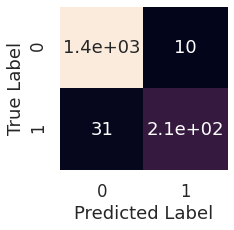

In [30]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

# Set font scale
sns.set(font_scale=1.5)

# Create a confusion matrix
conf_mat = confusion_matrix(history['y_test'], history['p_test'])


def plot_conf_mat_sb(conf_mat):
    """
    Plots a confusion matrix using seaborn's heatmap
    """
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(conf_mat,
                    annot=True,
                    cbar=False)
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plot_conf_mat_sb(conf_mat)